Data Preprocessing

In [2]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv("traffic.csv")

# Check for missing values and basic info
print(data.info())
print(data.isnull().sum())

# Drop rows with missing values in essential columns if any, or fill with zero/mean as needed
data.dropna(subset=['DateTime', 'Junction', 'Vehicles'], inplace=True)
data['Vehicles'].fillna(data['Vehicles'].mean(), inplace=True)

# Convert 'DateTime' column to pandas datetime format for time-based operations
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Sort data by DateTime to maintain chronological order for each junction
data = data.sort_values(by=['Junction', 'DateTime']).reset_index(drop=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None
DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64


/var/folders/hv/srlg7lv11zb9dm3jnh4mvy640000gn/T/ipykernel_3253/1742600282.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Vehicles'].fillna(data['Vehicles'].mean(), inplace=True)


In [3]:
# Extract features such as hour, day of the week, month, etc.
data['Hour'] = data['DateTime'].dt.hour
data['DayOfWeek'] = data['DateTime'].dt.dayofweek  # 0=Monday, 6=Sunday
data['Month'] = data['DateTime'].dt.month

# Add a feature for whether it's a weekend
data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Generate lagged features to capture prior traffic volumes at each junction
data['PrevHourVehicles'] = data.groupby('Junction')['Vehicles'].shift(1)
data['PrevDayVehicles'] = data.groupby('Junction')['Vehicles'].shift(24)  # Assuming hourly data

# Fill missing lagged values (if any) with mean or zero
data['PrevHourVehicles'].fillna(data['PrevHourVehicles'].mean(), inplace=True)
data['PrevDayVehicles'].fillna(data['PrevDayVehicles'].mean(), inplace=True)


/var/folders/hv/srlg7lv11zb9dm3jnh4mvy640000gn/T/ipykernel_3253/3556420057.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['PrevHourVehicles'].fillna(data['PrevHourVehicles'].mean(), inplace=True)
/var/folders/hv/srlg7lv11zb9dm3jnh4mvy640000gn/T/ipykernel_3253/3556420057.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

In [5]:
!pip install seaborn

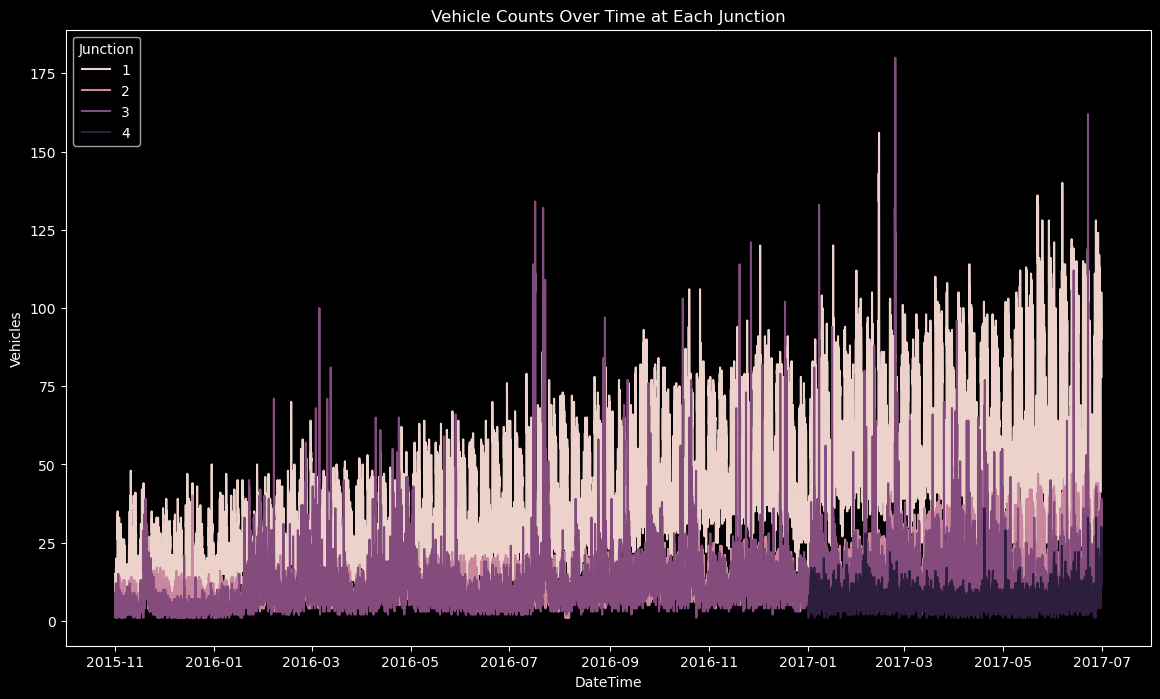

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot vehicle counts over time for each junction
plt.figure(figsize=(14, 8))
sns.lineplot(data=data, x='DateTime', y='Vehicles', hue='Junction')
plt.title('Vehicle Counts Over Time at Each Junction')
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.legend(title='Junction')
plt.show()


Feature Engineering

In [13]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Filter data for one junction as an example (e.g., Junction 1)
junction_data = data[data['Junction'] == 1].copy()

# Scaling the data for better performance of LSTM
scaler = MinMaxScaler()
junction_data[['Vehicles', 'PrevHourVehicles', 'PrevDayVehicles', 'Hour', 'DayOfWeek', 'Month', 'IsWeekend']] = scaler.fit_transform(
    junction_data[['Vehicles', 'PrevHourVehicles', 'PrevDayVehicles', 'Hour', 'DayOfWeek', 'Month', 'IsWeekend']]
)

# Define the target and features
target = junction_data['Vehicles']
features = junction_data[['PrevHourVehicles', 'PrevDayVehicles', 'Hour', 'DayOfWeek', 'Month', 'IsWeekend']]

# Convert to sequences (using a window size of 24 hours as an example)
window_size = 24  # Use data from the past 24 hours to predict the next hour

X = []
y = []

for i in range(window_size, len(features)):
    X.append(features.iloc[i-window_size:i].values)  # Take past 'window_size' data points
    y.append(target.iloc[i])  # Predict next data point

# Convert to numpy arrays for model compatibility
X, y = np.array(X), np.array(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Model Training

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50


2024-11-13 19:41:43.109570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 19:41:43.110557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 19:41:43.111213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

362/365 [============================>.] - ETA: 0s - loss: 0.0064

2024-11-13 19:41:49.166967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 19:41:49.167911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 19:41:49.168477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

365/365 [==============================] - 6s 12ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 2/50
365/365 [==============================] - 4s 11ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 3/50
365/365 [==============================] - 4s 11ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 4/50
365/365 [==============================] - 4s 11ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 5/50
365/365 [==============================] - 4s 11ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 6/50
365/365 [==============================] - 4s 11ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/50
365/365 [==============================] - 4s 11ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 8/50
365/365 [==============================] - 4s 11ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/50
365/365 [==============================] - 4s 11ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 10/50
365/365 [==============================] - 4s 11ms/step - loss: 0.0015 - val_loss: 0.0011


Making Predictions

In [16]:
# Predict on test data
predictions = model.predict(X_test)

predictions_full = np.zeros((predictions.shape[0], scaler.n_features_in_))  # Assuming scaler was fitted on all 7 features
predictions_full[:, 0] = predictions.flatten()  # Replace '0' with the index of 'Vehicles' in the original dataset


# Inverse scale to get original vehicle counts (if needed)
predictions_inverse = scaler.inverse_transform(predictions_full)
predictions_final = predictions_inverse[:,0]
y_test_full = np.zeros((y_test.shape[0], scaler.n_features_in_))
y_test_full[:, 0] = y_test.flatten()
y_test_inverse = scaler.inverse_transform(y_test_full)
y_test_final = y_test_inverse[:, 0]

# Calculate Mean Squared Error (MSE) as a metric
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_final, predictions_final)
print("Mean Squared Error:", mse)


92/92 [==============================] - 0s 3ms/step
Mean Squared Error: 18.296279775115153


In [ ]:
print(predictions_final)

array([12.38169954, 46.85297638, 12.25736713, ..., 22.47401984,
       22.6139149 , 26.6630346 ])

In [25]:
print(y_test_final)

[15. 43. 14. ... 21. 26. 24.]


In [30]:
(sum(y_test_final - predictions_final))/(y_test_final.size)

-0.024190590672792722

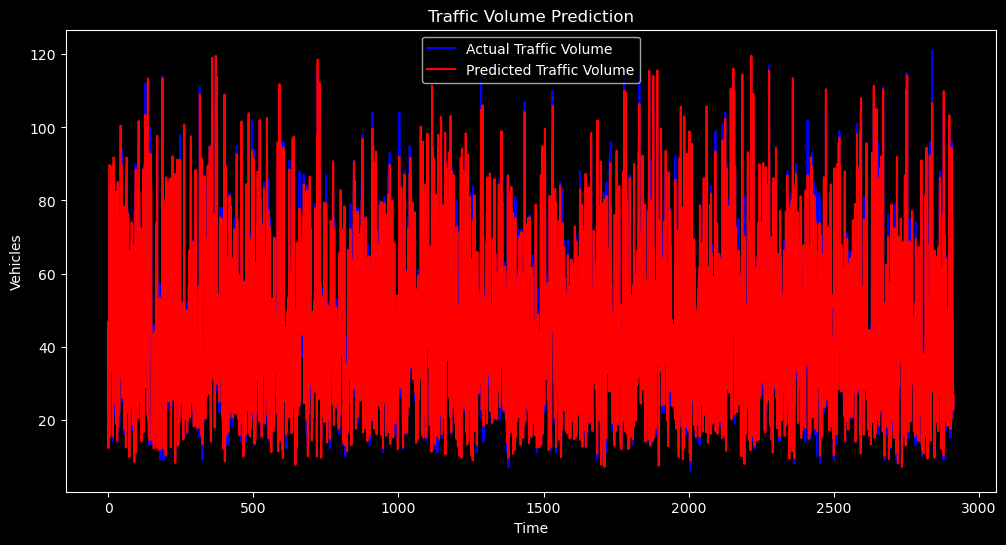

In [17]:
# Plot actual vs predicted vehicle counts
plt.figure(figsize=(12, 6))
plt.plot(y_test_final, color='blue', label='Actual Traffic Volume')
plt.plot(predictions_final, color='red', label='Predicted Traffic Volume')
plt.title('Traffic Volume Prediction')
plt.xlabel('Time')
plt.ylabel('Vehicles')
plt.legend()
plt.show()


In [36]:
# Example threshold values for traffic volume (you may adjust based on your needs)
LOW_TRAFFIC_THRESHOLD = 30
MEDIUM_TRAFFIC_THRESHOLD = 70

# Function to determine signal timings based on traffic volume prediction
def adjust_signal_timing(predicted_volume):
    if predicted_volume < LOW_TRAFFIC_THRESHOLD:
        green_time = 20  # seconds
    elif predicted_volume < MEDIUM_TRAFFIC_THRESHOLD:
        green_time = 40  # seconds
    else:
        green_time = 60  # seconds
    return green_time

# Simulating signal adjustment for each predicted traffic volume at each junction
predicted_volumes = model.predict(X_test).flatten()  # Example prediction data

for i, volume in enumerate(predicted_volumes[:10]):  # Take the first 10 predictions as an example
    green_time = adjust_signal_timing(volume)
    print(f"Prediction {i+1}: Predicted Traffic Volume = {volume:.2f}, Signal Green Time = {green_time} seconds")


92/92 [==============================] - 0s 3ms/step
Prediction 1: Predicted Traffic Volume = 0.05, Signal Green Time = 20 seconds
Prediction 2: Predicted Traffic Volume = 0.28, Signal Green Time = 20 seconds
Prediction 3: Predicted Traffic Volume = 0.05, Signal Green Time = 20 seconds
Prediction 4: Predicted Traffic Volume = 0.20, Signal Green Time = 20 seconds
Prediction 5: Predicted Traffic Volume = 0.20, Signal Green Time = 20 seconds
Prediction 6: Predicted Traffic Volume = 0.56, Signal Green Time = 20 seconds
Prediction 7: Predicted Traffic Volume = 0.07, Signal Green Time = 20 seconds
Prediction 8: Predicted Traffic Volume = 0.34, Signal Green Time = 20 seconds
Prediction 9: Predicted Traffic Volume = 0.20, Signal Green Time = 20 seconds
Prediction 10: Predicted Traffic Volume = 0.39, Signal Green Time = 20 seconds


Routing using dijkstra

In [19]:
import heapq

# Function to find the least congested path using Dijkstra's algorithm
def dijkstra(graph, start, end):
    # Initialize the priority queue and distances dictionary
    queue = [(0, start)]  # (cumulative traffic weight, current junction)
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    previous_nodes = {node: None for node in graph}

    while queue:
        current_weight, current_node = heapq.heappop(queue)
        
        # Early exit if we reach the destination
        if current_node == end:
            break
        
        for neighbor, weight in graph[current_node]:
            distance = current_weight + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                previous_nodes[neighbor] = current_node
                heapq.heappush(queue, (distance, neighbor))

    # Reconstruct the path from end to start
    path, current = [], end
    while current is not None:
        path.append(current)
        current = previous_nodes[current]
    path.reverse()

    return path if distances[end] != float('inf') else None, distances[end]

In [20]:
# Example graph as an adjacency list
graph = {
    'J1': [('J2', predicted_volumes[0])],
    'J2': [('J3', predicted_volumes[1])],
    'J3': [('J4', predicted_volumes[2])],
    'J4': [('J1', predicted_volumes[3])],
    # Add other nodes and edges as needed
}

# Find the least congested path
start_junction = 'J1'
end_junction = 'J3'
optimal_route, optimal_traffic = dijkstra(graph, start_junction, end_junction)
print("Optimal Route from", start_junction, "to", end_junction, ":", optimal_route)
print("Traffic Volume on Optimal Route:", optimal_traffic)


Optimal Route from J1 to J3 : ['J1', 'J2', 'J3']
Traffic Volume on Optimal Route: 0.32605745643377304


Alternate Routing using DFS


In [21]:
# Function to find all simple paths using DFS
def dfs_all_paths(graph, start, end, path=[]):
    path = path + [start]
    if start == end:
        return [path]
    
    paths = []
    for (neighbor, _) in graph.get(start, []):
        if neighbor not in path:  # Avoid cycles
            new_paths = dfs_all_paths(graph, neighbor, end, path)
            for new_path in new_paths:
                paths.append(new_path)
    return paths

# Function to calculate the traffic volume for a given path
def calculate_traffic_volume(graph, path):
    volume = 0
    for i in range(len(path) - 1):
        for neighbor, weight in graph[path[i]]:
            if neighbor == path[i + 1]:
                volume += weight
                break
    return volume

# Function to find the least congested alternative path under a traffic threshold
def find_alternative_path(graph, start, end, threshold):
    all_paths = dfs_all_paths(graph, start, end)
    alternative_paths = []

    # Filter paths with traffic volume under the threshold
    for path in all_paths:
        traffic_volume = calculate_traffic_volume(graph, path)
        if traffic_volume < threshold:
            alternative_paths.append((path, traffic_volume))
    
    # Select the path with the lowest traffic volume
    if alternative_paths:
        best_alternative = min(alternative_paths, key=lambda x: x[1])
        return best_alternative
    else:
        return None, None  # No path under the traffic threshold



In [22]:
# Example: Finding an alternative route if traffic is high on the optimal route
traffic_threshold = 200  # Example threshold for high traffic
alternative_route, traffic_volume = find_alternative_path(graph, start_junction, end_junction, traffic_threshold)
if alternative_route:
    print("Alternative Route from", start_junction, "to", end_junction, ":", alternative_route)
    print("Traffic Volume on Alternative Route:", traffic_volume)
else:
    print("No alternative route with lower traffic found.")


Alternative Route from J1 to J3 : ['J1', 'J2', 'J3']
Traffic Volume on Alternative Route: 0.32605745643377304
